In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import gridspec

import statsmodels.api as sm
import statsmodels.formula.api as smf

import json, os, requests
from IPython.display import Latex

In [46]:
# collect data and construct dataframe
from habanero import counts
urls = {
    'che': 'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6NJ5RN/FEOJIJ',
    'phy': 'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6NJ5RN/47AAHP',
    'med': 'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6NJ5RN/LOV9VR',
}

# get all datasets on the papers
paper = pd.DataFrame()
for k, v in urls.items():
    a = pd.read_csv(v, encoding='utf8', sep='\t')
    a['category'] = k
    paper = paper.append(a)
paper.columns = ['LID', 'name', "prize_year", 'title', 'pub_year', 'paper_id', 'DOI', 'journal', 'affiliation', 'winning', 'category']


# compose the dataset of the Nobel laureates
people = {
    'name': [], 
    'family_name': [], 
    'gender': [], 
    'birth': [], 
    'birth_country': [],
    'country_now': [],
    'prize_year': [],
    'death': [],
    'category': []
}

for category in ['che', 'phy', 'med']:
    url = f'https://api.nobelprize.org/2.0/laureates?offset=0&limit=300&format=json&nobelPrizeCategory={category}'
    laureates = requests.get(url).json()['laureates']
    for l in laureates:
        for p in l['nobelPrizes']:
            people['name'].append(l['fullName']['en'])
            people['family_name'].append(l['familyName']['en'])
            people['gender'].append(l.get('gender', ''))
            people['birth'].append(l['birth']['date'])
            people['birth_country'].append(l['birth']['place']['country']['en'])
            people['country_now'].append(l['birth']['place']['countryNow']['en'])
            people['prize_year'].append(p['awardYear'])
            if l.get('death'):
                people['death'].append(l['death']['date'])
            else:
                people['death'].append('')
            people['category'].append(category)
people = pd.DataFrame(people)
people['prize_year'] = people.prize_year.astype(int)


# perform a inner join between the laureates and the papers
people_paper = paper[['LID', 'name', 'prize_year', 'category']].drop_duplicates()
people_paper = people_paper.merge(people, on=['prize_year', 'category'])
def match_people(row):
    last_name = row['name_x'].split(", ")[0].split(" ")[0].lower()[:5]
    return last_name in row['name_y'].lower()
people_paper = people_paper.loc[people_paper.apply(match_people, axis=1)]
people_paper = paper.merge(people_paper)
winning_paper = people_paper.loc[people_paper.winning == 'YES'].copy()


# get all citations for the prize winning papers 
winning_paper['citation'] = winning_paper.DOI.apply(lambda x: counts.citation_count(doi = x) if not pd.isna(x) else -1)
winning_paper.birth = winning_paper.birth.apply(lambda x: int(x[:4]))


# calculate the timing ratio as from our definition
person_stage = winning_paper[['LID', 'pub_year']]
person_stage.columns = ['LID', 'prized_paper_pub_year']
people_paper = people_paper.merge(person_stage)
paper_before = people_paper.loc[people_paper.apply(lambda row: row.pub_year <= row.prized_paper_pub_year,
                                                   axis=1)]\
               .groupby('name')['DOI'].count()\
               .reset_index()
paper_total = people_paper.groupby('name')['DOI'].count().reset_index()
ratio = paper_total.merge(paper_before, on='name')
ratio['ratio'] = (ratio['DOI_y'] - 1) / (ratio['DOI_x'])
winning_paper = winning_paper.merge(ratio, on='name').dropna(subset=['DOI'])


# some cleaning and drop unnecessary columns
winning_paper = winning_paper.loc[winning_paper.citation > 0]
winning_paper = winning_paper[['LID', 'name', 'prize_year', 'gender', 'birth', 
                               'birth_country', 'country_now', 'death', 'category',
                               'title', 'pub_year', 'DOI', 'citation', 
                               'ratio', 'DOI_x', 'DOI_y']]
winning_paper.columns = list(winning_paper.columns[:-2]) + ['num_paper_total', 'num_paper_before']
winning_paper = winning_paper.loc[winning_paper.apply(lambda row: row.pub_year <= row.prize_year, axis=1)]

# get team size
team_size = winning_paper.groupby('DOI')['LID'].count().reset_index()
team_size.columns = ['DOI', 'team_size']
winning_paper = winning_paper.merge(team_size)

# get age at the publication
winning_paper['pub_age'] = winning_paper.pub_year - winning_paper.birth
winning_paper = winning_paper.loc[winning_paper.pub_age > 15]

# Save it to a csv so that we dont have to download it again
# winning_paper.to_csv("winning_paper.csv", index=False)

In [4]:
# # read the cleaned dataset
# winning_paper = pd.read_csv("winning_paper.csv")

# _Summary_

_Based on the research on Nobel Prize Laureates and their prize papers, this report examines the relationship between the scientific impact of a paper and the timing of a paper during a scientist's career. The report also investigates on the effect of different factors on the scientific impact and the timing. By building Poisson regression models and using stratified analysis, the analysis shows some evidence of relationship between the scientific impact and timing of a paper, and the relationship is higher dependent on the publication year._ 

# 1. Introduction

Albert Einstein developed the theory of relativity at the age of 26, Ludwig Boltzmann predicted the properties of atoms at the age of 28. A common belief on scientists is that there is an early peak on productivity and then quickly declines. With the examinations on the some of the most genius scientists, the Nobel Prize winners of natural science, we try to model how scientific impact is influenced by the timing of the scientist's career.  

The paper's scientific impact will be measured by its number of citations. Rather than other Scientometrics measurements such as IF, citation number is the most accessible and universal for our time range. The paper's timing during a scientist's career will be measured in the ratio as 
$$\text{ratio} = \frac{\text{Number of papers before the scientist's fist prize-winning paper}}{\text{Number of papers the scientist produced up to winning Nobel Prize}}$$
Using this ratio allows us to focus on the stage of a scholar's career rather than his/her overall life.

The scope of the research is on prize-winning papers from laureates of Nobel Prize in Physics, Chemistry, and Medicine, from 1880 to 2010. After cleaning on the original datasets on papers \cite{DVN/6NJ5RN_2018}, the report is analyzed on 713 prize-winning papers and 453 laureates. 

# 2. Methodology

## 2.1. Investigations on factors

First,we tried a log transformation, which is a common link function for Poisson regression. By looking at the scatter plots in Figure 1, the log number of citations gives more constant variance over the number of citations. Therefore, we assume that the number of citations follows a Poisson distribution rather than a Normal distribution. However, there is no obvious relationship between the two variables. 

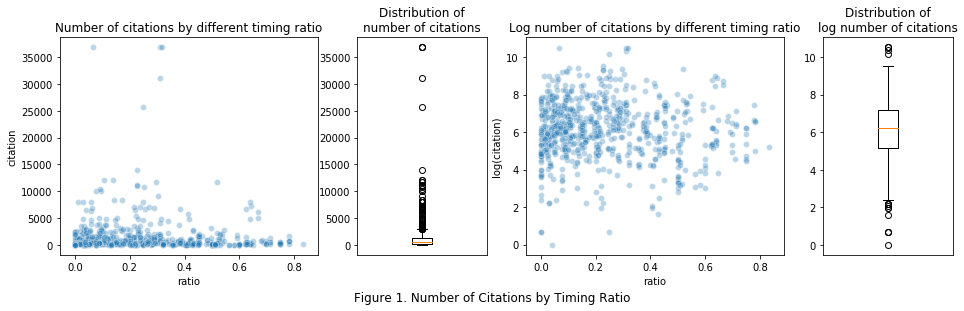

In [6]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[2, 1, 2, 1])
plt.subplot(gs[0])
sn.scatterplot(x='ratio', y='citation', data=winning_paper, alpha=.3)
plt.title("Number of citations by different timing ratio")
plt.subplot(gs[1])
plt.boxplot(winning_paper.citation)
plt.title("Distribution of\nnumber of citations")
plt.xticks([], [])
plt.subplot(gs[2])
sn.scatterplot(x='ratio', y=np.log(winning_paper.citation), data=winning_paper, alpha=.3)
plt.title("Log number of citations by different timing ratio")
plt.ylabel("log(citation)")
plt.subplot(gs[3])
plt.boxplot(np.log(winning_paper.citation))
plt.title("Distribution of\nlog number of citations")
plt.xticks([], [])
fig.suptitle("Figure 1. Number of Citations by Timing Ratio", y=0.)

winning_paper['log_citation'] = np.log(winning_paper.citation);

I proposed some possible factors that may affect the relationship. Consider gender, prize category, and team size side-by-side box plots are used to see the differences of the variable's distribution within each group of the researched factor.

In [7]:
def analyze_categorical_factor(df, column, title=""):
    fig = plt.figure(figsize=(14, 3))
    plt.subplot(131)
    plt.title(f"Number of Observations \nin each category of {column}")
    sn.countplot(df[column])
    plt.subplot(132)
    sn.boxplot(x=column, y="ratio", data=df, showmeans=True, color='white')
    plt.title(f"Boxplot of {column} vs. ratio")
    plt.subplot(133)
    sn.boxplot(x=column, y="log_citation", data=df, showmeans=True, color='white')
    plt.title(f"Boxplot of {column} vs. log citation")
    fig.suptitle(title, y=-.1)
    plt.show()

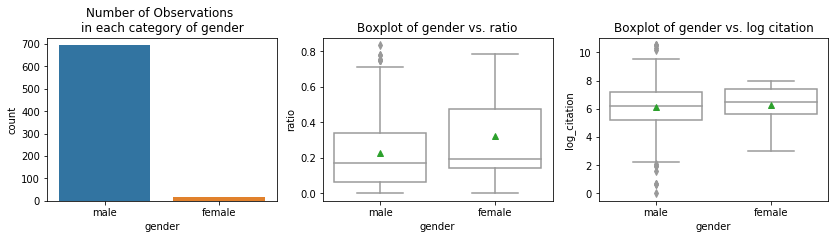

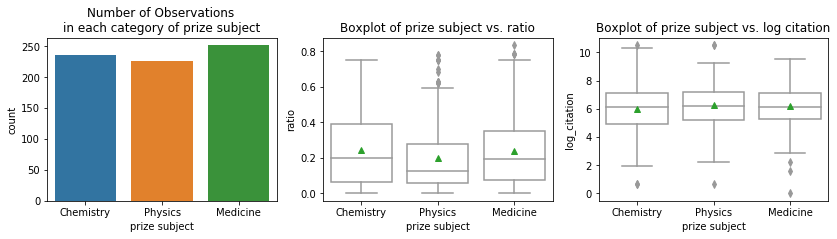

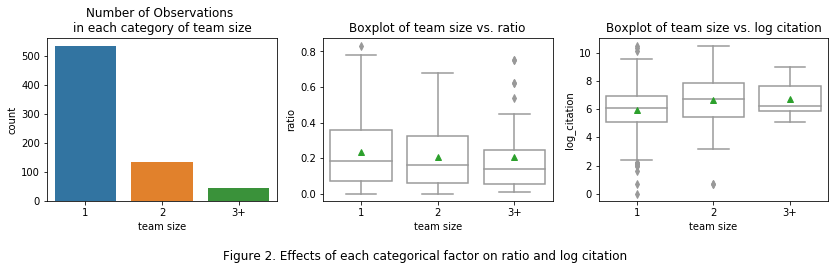

In [8]:
df = winning_paper[['category', 'ratio', 'log_citation', 'team_size', 'gender']].copy()
def expand_subject_name(x):
    if x == "che":
        return "Chemistry"
    elif x == "phy":
        return "Physics"
    else:
        return "Medicine"
df['prize subject'] = df.category.apply(expand_subject_name)
df['team size'] = df.team_size.apply(lambda x: "3+" if x >= 3 else str(x))
analyze_categorical_factor(df, "gender");
analyze_categorical_factor(df, "prize subject");
analyze_categorical_factor(df, "team size", title="Figure 2. Effects of each categorical factor on ratio and log citation")

For gender, although there is some minor differences on the statistics of ratio and log citation between males and females. Due to the extremely imbalanced number within each group, the difference is statistically insignificant. 

Prize category seems to be associated with the timing ratio, where physicists seems to have their most significant work earlier in their career. However, the difference is not very significant. Also, prize category seems to be independent of citation number. 

Team size might be a confounding variable for its impact on both ratio and log citation. However, due to the imbalanced sample sizes, there are only weak evidences. 

I excluded the analysis on age because there is definitely a strong association between the ratio and the scientist's age at the publication. Including age will cause perfect multicollinearity on predicting the log number of citation. 

Finally, notice that publication years will have strong positive association with citation numbers. Due to the publication explosion, the number of scientific publications grew by $4.6\%$ annually \cite{larsen2010rate}. Shown in Figure 2, there is a strong evidence that log citation number has a positive linear relationship with the publication year, which suggests a exponential growth of citations across the years. However, we are not clear about the relationship between the timing ration and the publication year.

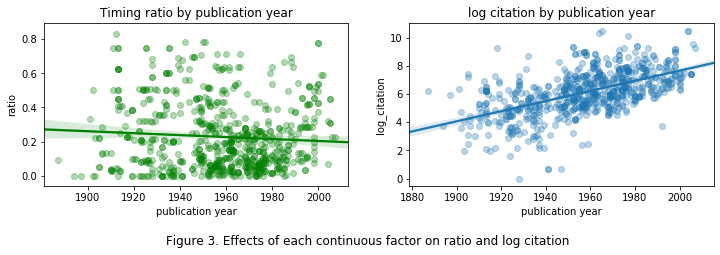

In [9]:
df = winning_paper[['ratio', 'log_citation', 'pub_age', 'pub_year']]
df.columns = ['ratio', 'log_citation', 'age at publication', 'publication year']

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
sn.regplot(x="publication year", y="ratio", data=df, scatter_kws={'alpha': .3}, color="green")
plt.title("Timing ratio by publication year")
plt.subplot(122)
sn.regplot(x="publication year", y="log_citation", data=df, scatter_kws={'alpha': .3})
plt.title(f"log citation by publication year")

fig.suptitle("Figure 3. Effects of each continuous factor on ratio and log citation", y=-.1)
plt.show()

## 2.2. Models

Based on the investigations, we are interested in whether team size has impact on citation number and how publication year is related to the timing ratio and citation. From the investigations, the Poisson model will be appropriate for the data. In addition, notice that there are multiple papers that belong to the same scholar. We make the assumption that each laureate will have similar behavior on their papers, i.e. random effect from laureates on citation numbers. Therefore, we assume a underlying Poisson mixed effect models. 3 candidate models are proposed after some considerations. note that we use $\text{year} = \text{publication year} - 1880$ so that the baseline is set to the minimum publication year in our research subject, and $\text{ratio}$ is multiplied by 100 so that one unit change will be $1\%$ change in the actual ratio. 

Model 1 is the additive model with the hypothesis that the timing ratio is independent of publication year. The model is defined as 
\begin{align*}
\log(\text{citation}) &= \beta_0 + \beta_1R + \beta_2Y + \beta_3T2 + \beta_4T3\\&\quad+ \gamma_1\text{laureate}+\epsilon
\end{align*}
Model 2 is the interaction model with the hypothesis that there are two-way interactions among the three factors. The model is defined as

\begin{align*}
\log(\text{citation}) &= \beta_0 + \beta_1R + \beta_2Y + \beta_3T2 + \beta_4T3\\
&\quad + \beta_5R:T2 + \beta_6 R:T3\\
&\quad + \beta_7 Y:T2 + \beta_8 R:T3\\
&\quad + \beta_7 R:Y\\
&\quad+ \gamma_1\text{laureate}+\epsilon
\end{align*}

Model 3 is the stratified analysis. I divided the publication years into 3 groups, $1880\sim 1930, 1931\sim 1980, 1981\sim 2010$, and perform regression on each group with additive models. The year intervals are suggested by Larsen & von Ins \cite{larsen2010rate}, which are 3 time intervals with different growth rate. Each model is defined as
\begin{align*}
\log(\text{citation}|YG) &= \beta_0 + \beta_1R|YG + \beta_2T2|YG + \beta_3T3|YG\\&\quad+ \gamma_1\text{laureate}|YG+\epsilon
\end{align*}
where $R$ is for ratio, $Y$ is for year, and $T2$ is for team size of 2, $T3$ is team size more than or equal to 3. 

In [39]:
df = winning_paper[['citation', 'ratio', 'team_size', 'pub_year', 'LID']].copy()
def apply_year_group(x):
    if x <= 1930:
        return "1880-1930"
    elif x <= 1980:
        return "1931-1980"
    else:
        return "1981-2010"
df['year_group'] = df['pub_year'].apply(apply_year_group)
df['year'] = df.pub_year - 1880
df['team_size'] = df.team_size.apply(lambda x: "3+" if x >= 3 else str(x))

In [40]:
%load_ext rpy2.ipython
%R -i df

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
%%R
# import lme4 if not found
if(!require(lme4)){
    install.packages("lme4")
    library(lme4)
}

# fit the models as specified above
df$LID <- as.factor(df$LID)
df['ratio'] <- df['ratio'] * 100

model1 <- glmer(citation ~ ratio + team_size + year + (1 | LID), 
                data=df, family=poisson)
model2 <- glmer(citation ~ ratio + team_size + year + ratio* team_size + ratio * year + year * team_size + (1 | LID), 
                data=df, family=poisson)
model31 <- glmer(citation ~ ratio + team_size + (1 | LID), 
                data=df[df$year_group == '1880-1930', ], family=poisson)
model32 <- glmer(citation ~ ratio + team_size + (1 | LID), 
                data=df[df$year_group == '1931-1980', ], family=poisson)
model33 <- glmer(citation ~ ratio + team_size + (1 | LID), 
                data=df[df$year_group == '1981-2010', ], family=poisson)

# 3. Results

The fitted coefficients and standard errors of the models are shown in Figure 4; and the fit statistics are shown in the table below. Model31, Model32, Model33 are for Model3 for 1880-1930, 1931-1980, 1981-201 groups, respectively. 

In [42]:
model_coefs = {}
model_stats = {}
# Transfer all R results into Python
%R -o model1_coef model1_coef = as.data.frame(summary(model1)$coefficients)
model_coefs['model1'] = model1_coef
%R -o model2_coef model2_coef = as.data.frame(summary(model2)$coefficients)
model_coefs['model2'] = model2_coef
%R -o model31_coef model31_coef = as.data.frame(summary(model31)$coefficients)
model_coefs['model31'] = model31_coef
%R -o model32_coef model32_coef = as.data.frame(summary(model32)$coefficients)
model_coefs['model32'] = model32_coef
%R -o model33_coef model33_coef = as.data.frame(summary(model33)$coefficients)
model_coefs['model33'] = model33_coef

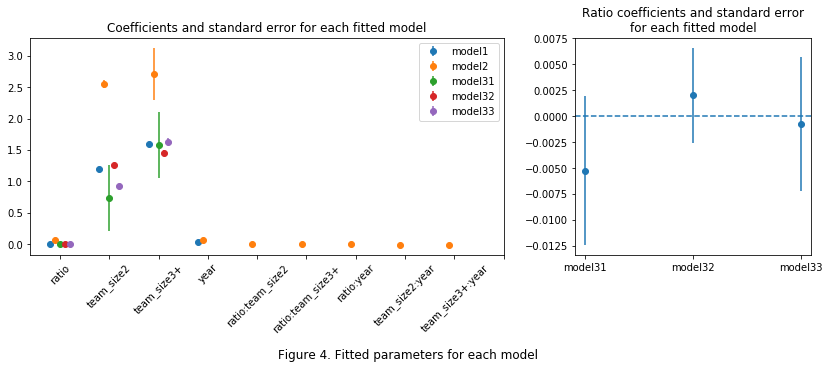

In [43]:
shift = -.2
fig, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [2, 1]})
for mc in model_coefs.keys():
    x = np.arange(1, len(model_coefs[mc]['Estimate'][1:].index)+1)+ shift
    y = model_coefs[mc]['Estimate'][1:]
    yerr = model_coefs[mc]['Std. Error'][1:]
    axs[0].errorbar(x=x, y=y, yerr=yerr, linestyle='None', marker='o', label=mc)
    shift += .1
axs[0].set_xticks(np.arange(1, 11))
axs[0].set_xticklabels(model_coefs['model2']['Estimate'][1:].index)
axs[0].tick_params("x", rotation=45)
axs[0].legend()
axs[0].set_title("Coefficients and standard error for each fitted model")
x, y, yerr = [], [], []
for m in ['model31', 'model32', 'model33']:
    x.append(m)
    y.append(model_coefs[m]['Estimate'][1])
    yerr.append(model_coefs[m]['Std. Error'][1])
axs[1].errorbar(x=x, y=y, yerr=yerr, linestyle='None', marker='o')
axs[1].axhline(0, linestyle="--")
axs[1].set_title("Ratio coefficients and standard error\nfor each fitted model")
fig.suptitle("Figure 4. Fitted parameters for each model", y=-.2);

In [44]:
%R -o model1_stats model1_stats = as.data.frame(summary(model1)$AIC)
model_stats['model1'] = model1_stats.transpose()
%R -o model2_stats model2_stats = as.data.frame(summary(model2)$AIC)
model_stats['model2'] = model2_stats.transpose()
%R -o model31_stats model31_stats = as.data.frame(summary(model31)$AIC)
model_stats['model31'] = model31_stats.transpose()
%R -o model32_stats model32_stats = as.data.frame(summary(model32)$AIC)
model_stats['model32'] = model32_stats.transpose()
%R -o model33_stats model33_stats = as.data.frame(summary(model33)$AIC)
model_stats['model33'] = model33_stats.transpose()

In [45]:
summary_stats = pd.DataFrame()
for mc in model_stats.keys():
    model_stats[mc].index = [mc]
    summary_stats = summary_stats.append(model_stats[mc].reset_index())
summary_stats = summary_stats.iloc[:, :-1]
summary_stats.columns = ['model', 'AIC', 'BIC', 'log likelihood', 'deviance']

display(Latex(r'\begin{table}\centering' + \
              summary_stats.to_latex(index=False) + \
              r'\end{table}'))

<IPython.core.display.Latex object>

First, notice that the fitted value for ratio and interaction terms with ratio are all approximately 0 for all fitted models. Therefore, $1\%$ change in the timing ratio is likely to have no effect on the number of citations. The standard errors and p-values are quite small due to the large sample size, while the extremely small coefficients hints that there is no relationship between citation and timing ratio.

Second, shown by the coefficients on team sizes, there are evidences that laureates that worked in teams have higher citation numbers than laureates that worked alone. However, the differences between team size of 2 and 3 is not significant. From Model3, the large p-value may suggest that the association between team size and citation numbers is less likely to be significant. 

Moreover, Model2 has slightly higher log-likelihood and BIC than Model1, hence the interaction model is probably a better fit than the additive model. Also, consider the models on the 3 year groups, the coefficients for ratios are different and the signs overturn for Model32. This gives some evidence that publication year is a confounding variable for ratio and number of citations. 

# 4. Conclusion
This report investigates the relationship between a paper's scientific impact, as measured in citation numbers, and the timing of the paper during a scientist's career, as measured in a ratio. By proposing and analyzing several Poisson mixed effect models, we conclude that there are strong evidence that timing is independent of the scientific impact. The scientific impact is more likely to be effected by the team size and publication years. Also, the way that scientific research is conducted was evolved through time, as the publication years is likely to be a confounding variable for scientific impact and timing. 

In this analysis, we have to note that the AIC, BIC, and log-likelihoods are quite large for all the examined models. These fitted statistics hint that the fitted models are likely to be invalid. Further research should consider different models and how publication year impacts other factors. 